Suggestions (sans modifier ton code)

captions_csv_path = os.path.join(dataset_dir, "captions.csv")

Souvent le fichier est dans dataset_dir/captions/captions.csv.

Suggestion: vérifier la structure du zip (os.walk) et ajuster le chemin si besoin.

TransformerBlock.get_config est “dans” call() (indentation)

Ton get_config ne sera pas une vraie méthode de classe.

Suggestion: sortir def get_config(...) au niveau de la classe.

Tu as 2 normalisations L2 (L2Normalize et L2Norm)

Pas bloquant, mais redondant.

Suggestion: garder une seule couche L2 (pour clarté).

La partie “SmallBERT” est définie mais pas utilisée dans build_text_encoder

Tu utilises un encodeur texte simple (Embedding + AveragePooling).

Suggestion: si tu veux vraiment “SmallBERT”, remplacer l’encodeur texte par SmallBERT + pooling (SelectFirstToken/MaskedMean).

Dans un fichier .py (hors notebook), "%cd" ne marche pas

Suggestion: remplacer par os.chdir(my_local_drive) si export vers Python.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import sys
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/ML_FDS'
sys.path.append(my_local_drive)

# Check that the directory actually exists
import os
print(os.path.isdir(my_local_drive))

import os
import pandas as pd
import re
import numpy as np
import random
import zipfile
import requests
import io
import math
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.metrics import Mean
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from numpy.linalg import norm

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder

# Pour utiliser au mieux le GPU
AUTOTUNE = tf.data.AUTOTUNE


Mounted at /content/gdrive
False


In [2]:
def preview_images_from_dir(image_dir, image_size=(224, 224), n=12,
                            subset="training", seed=123):
    """
    BUT
    ----
    Afficher un échantillon de n images + leurs labels depuis un dossier structuré
    pour `flow_from_directory`.

    ENTREE
    ------
    image_dir : chemin vers le dossier images/ contenant des sous-dossiers par classe
    image_size: taille (H,W) de redimensionnement
    n         : nombre d'images à afficher
    subset    : "training" ou "validation" (via validation_split=0.2)
    seed      : pour reproductibilité du shuffle

    PRINCIPE
    --------
    - Crée un ImageDataGenerator avec rescale et validation_split
    - Construit un générateur flow_from_directory
    - Récupère un batch (imgs, y) et affiche en grille
    """
    preview_datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

    preview_gen = preview_datagen.flow_from_directory(
        image_dir,
        target_size=image_size,
        batch_size=n,
        class_mode="categorical",
        subset=subset,
        shuffle=True,
        seed=seed
    )

    # imgs: (n, H, W, 3) ; y: one-hot (n, nb_classes)
    imgs, y = next(preview_gen)
    class_names = list(preview_gen.class_indices.keys())
    labels = np.argmax(y, axis=1)

    # Affichage en grille (3 lignes, colonnes calculées)
    rows = 3
    cols = int(np.ceil(n / rows))
    plt.figure(figsize=(4*cols, 4*rows))
    for i in range(min(n, imgs.shape[0])):
        plt.subplot(rows, cols, i+1)
        plt.imshow(imgs[i])
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [3]:
@register_keras_serializable()
class SelectFirstToken(layers.Layer):
    # BUT: prendre le premier token (souvent le token [CLS] dans des modèles type BERT)
    def call(self, inputs):
        # inputs: (batch, seq_len, embed_dim)
        # retourne: (batch, embed_dim)
        return inputs[:, 0]


@register_keras_serializable()
class SelectMean(layers.Layer):
    # BUT: moyenne simple sur la dimension seq_len
    # utile si toutes les séquences ont une longueur équivalente (ou peu de PAD)
    def call(self, inputs):
        # inputs: (batch, seq_len, embed_dim)
        return tf.reduce_mean(inputs, axis=1)  # (batch, embed_dim)


@register_keras_serializable()
class MaskedMean(layers.Layer):
    # BUT: moyenne masquée pour réduire l'influence du padding (PAD=0)
    def call(self, inputs):
        # seq_out: sorties par token (B,L,D)
        # token_ids: ids des tokens (B,L)
        seq_out, token_ids = inputs

        # mask = 1 si token != 0, sinon 0 (PAD)
        mask = tf.cast(tf.not_equal(token_ids, 0), seq_out.dtype)  # (B,L)
        mask = tf.expand_dims(mask, -1)                            # (B,L,1)

        # somme pondérée par le mask
        summed = tf.reduce_sum(seq_out * mask, axis=1)             # (B,D)
        counts = tf.reduce_sum(mask, axis=1)                       # (B,1)

        # moyenne = summed / nb_tokens_non_PAD
        return summed / tf.maximum(counts, 1.0)


In [4]:
@register_keras_serializable()
class L2Normalize(layers.Layer):
    """
    BUT
    ---
    Appliquer une normalisation L2 sur les embeddings.
    En CLIP, cela permet de transformer un produit scalaire en similarité cosinus.

    axis : axe de normalisation (souvent -1 pour la dimension embedding)
    """
    def __init__(self, axis=-1, **kwargs):
        super().__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=self.axis)

    def get_config(self):
        config = super().get_config()
        config.update({"axis": self.axis})
        return config


In [5]:
@tf.keras.utils.register_keras_serializable()
class PositionalEmbedding(layers.Layer):
    """
    BUT
    ---
    Faire un embedding de tokens + embedding de positions, puis additionner.
    - token_embeddings: (vocab_size -> embed_dim)
    - position_embeddings: (sequence_length -> embed_dim)

    compute_mask:
    - renvoie un mask booléen (token != 0) pour supporter le padding.
    """
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=vocab_size,
                                                 output_dim=embed_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length,
                                                    output_dim=embed_dim)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(0, length)                 # positions: (L,)
        embedded_tokens = self.token_embeddings(inputs) # (B,L,D)
        embedded_positions = self.position_embeddings(positions)  # (L,D)
        return embedded_tokens + embedded_positions     # broadcasting -> (B,L,D)

    def compute_mask(self, inputs, mask=None):
        return tf.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config


In [ ]:
@tf.keras.utils.register_keras_serializable()
class TransformerBlock(layers.Layer):
    """
    BUT
    ---
    Bloc Transformer standard:
    - MultiHeadAttention + residual + LayerNorm
    - FeedForward (Dense -> Dense) + residual + LayerNorm
    - Dropout

    supports_masking=True:
    - permet d'utiliser un mask sur la séquence (padding).
    """
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True

        # Multi-head self-attention
        self.att = layers.MultiHeadAttention(num_heads=num_heads,
                                             key_dim=embed_dim)

        # Feed-forward network (FFN)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])

        # Normalisations et dropouts
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training=False, mask=None):
        # inputs: (B,L,D)
        seq_len = tf.shape(inputs)[1]
        attn_mask = None

        # Si mask existe (B,L), on le met au format attendu pour attention_mask
        if mask is not None:
            attn_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.float32)  # (B,1,L)
            attn_mask = tf.tile(attn_mask, [1, seq_len, 1])                # (B,L,L)

        # Self-attention
        attn_output = self.att(inputs, inputs, inputs, attention_mask=attn_mask)
        attn_output = self.dropout1(attn_output, training=training)

        # Residual + LayerNorm
        out1 = self.layernorm1(inputs + attn_output)

        # FFN
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)

        # Residual + LayerNorm
        return self.layernorm2(out1 + ffn_output)

        def get_config(self):
            config = super().get_config()
            config.update({
                "embed_dim": self.att.key_dim,
                "num_heads": self.att.num_heads,
                "ff_dim": self.ffn.layers[0].units,
                "dropout_rate": self.dropout1.rate,
            })
            return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [7]:
@register_keras_serializable()
class SmallBERT(tf.keras.Model):
    """
    BUT
    ---
    Petit encodeur Transformer:
    - PositionalEmbedding
    - num_layers TransformerBlock
    - LayerNorm + Dropout final

    SORTIE
    ------
    Renvoie une séquence encodée (B,L,D) (pas un pooling).
    Pour obtenir un embedding (B,D), il faut ensuite un pooling
    (SelectFirstToken / SelectMean / MaskedMean).
    """
    def __init__(self, sequence_length, vocab_size, embed_dim, num_heads,
                 ff_dim, num_layers, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(sequence_length, vocab_size,
                                                 embed_dim)

        self.transformer_blocks = [
            TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_layers)
        ]
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout = tf.keras.layers.Dropout(0.1)

    def call(self, inputs, training=False):
        x = self.pos_embedding(inputs)  # (B,L,D)
        for block in self.transformer_blocks:
            x = block(x, training=training)  # (B,L,D)
        x = self.layernorm(x)
        return self.dropout(x, training=training)

    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "num_layers": self.num_layers,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [8]:
@register_keras_serializable(package="clip")
class ClipLossLayer(layers.Layer):
    """
    BUT
    ---
    Implémenter la loss contrastive CLIP:
    - On calcule la similarité (image_embeds dot text_embeds) / temperature
    - On force la diagonale à être la meilleure correspondance
      (image i <-> texte i dans le batch)

    IMPORTANT
    ---------
    - suppose que img et txt sont L2-normalisés.
    - ajoute la loss via self.add_loss(loss) (pas besoin de fournir y).
    """
    def __init__(self, temperature=0.07, **kwargs):
        super().__init__(**kwargs)
        self.temperature = temperature
        self.clip_loss_metric = tf.keras.metrics.Mean(name="clip_loss")

    def call(self, inputs):
        img, txt = inputs  # (B,D)

        # Similarités (cosinus si embeddings L2)
        logits = tf.matmul(img, txt, transpose_b=True) / self.temperature  # (B,B)

        # Labels implicites = diagonale (0..B-1)
        labels = tf.range(tf.shape(logits)[0])

        # Loss image->texte et texte->image
        li = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
        lt = tf.keras.losses.sparse_categorical_crossentropy(labels, tf.transpose(logits), from_logits=True)
        loss = tf.reduce_mean(li + lt) / 2.0

        self.add_loss(loss)
        self.clip_loss_metric.update_state(loss)

        # Retourne un tuple (utile si on veut récupérer les embeddings en sortie)
        return (img, txt)

    def get_config(self):
        return {**super().get_config(), "temperature": self.temperature}


In [9]:
def make_clip_dataset_smallbert(
    captions_csv_path,
    tokenizer_layer,
    batch_size=32,
    shuffle=True,
    drop_remainder=True,
    cache=True,
    seed=42,
):
    """
    BUT
    ---
    Construire un tf.data.Dataset prêt pour l'entraînement CLIP.

    ENTREE
    ------
    captions_csv_path : chemin vers captions.csv (colonnes attendues: image_path, caption)
    tokenizer_layer   : TextVectorization (déjà adapt)
    batch_size        : taille batch
    shuffle           : mélange dataset
    drop_remainder    : retire le dernier batch s'il est incomplet
    cache             : met en cache après map (accélère)
    seed              : reproductibilité shuffle

    SORTIE
    ------
    ds yield:
      {"image_input": img_tensor (224,224,3), "text_input": token_ids (L,)}
    """
    df = pd.read_csv(captions_csv_path)
    image_paths = df["image_path"].astype(str).tolist()
    captions    = df["caption"].fillna("").astype(str).tolist()

    # Utilise dataset_dir global (défini plus haut) pour reconstruire le chemin complet
    root = Path(dataset_dir)
    full_paths = [str(root / p) for p in image_paths]

    ds = tf.data.Dataset.from_tensor_slices((full_paths, captions))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(full_paths), seed=seed,
                        reshuffle_each_iteration=True)

    def load_sample(img_path, caption):
        # Lecture + décodage + resize + normalisation [0,1]
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [224, 224])
        img = tf.image.convert_image_dtype(img, tf.float32)

        # Tokenisation du texte en séquence d'entiers
        tokens = tf.cast(tokenizer_layer(caption), tf.int32)

        # Le modèle attend exactement ces clés ("image_input", "text_input")
        return {"image_input": img, "text_input": tokens}

    ds = ds.map(load_sample, num_parallel_calls=AUTOTUNE)
    if cache:
        ds = ds.cache()

    ds = ds.batch(batch_size, drop_remainder=drop_remainder).prefetch(AUTOTUNE)
    return ds


In [10]:
@tf.keras.utils.register_keras_serializable()
class L2Norm(layers.Layer):
    # BUT: normaliser L2 (équivalent à L2Normalize mais autre classe)
    def call(self, inputs):
        return tf.nn.l2_normalize(inputs, axis=-1)


In [11]:
def build_image_encoder(image_shape=(224, 224, 3), embed_dim=128):
    """
    BUT
    ---
    Encodeur CNN simple -> embedding (B,embed_dim) normalisé.
    """
    img_in = layers.Input(shape=image_shape, name="image_input_raw")

    x = layers.Conv2D(32, 3, activation="relu", padding="same")(img_in)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(embed_dim, activation=None)(x)
    x = L2Norm(name="image_l2norm")(x)   # normalisation -> similarité cosinus

    return Model(img_in, x, name="image_encoder")


In [12]:
def build_text_encoder(vocab_size, sequence_length, embed_dim=128):
    """
    BUT
    ---
    Encodeur texte simple:
    - Embedding token
    - Moyenne sur la séquence
    - Dense -> embed_dim
    - L2 normalisation
    """
    txt_in = layers.Input(shape=(sequence_length,), dtype="int32", name="text_input_raw")

    x = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=False)(txt_in)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(embed_dim, activation=None)(x)
    x = L2Norm(name="text_l2norm")(x)

    return Model(txt_in, x, name="text_encoder")


In [13]:
def load_img_224(p):
    """
    BUT
    ---
    Charger une image, la décoder, la resize en 224x224, et normaliser en float32 [0,1].
    Utilisé pour construire un dataset batché et calculer les embeddings image.
    """
    x = tf.io.read_file(p)
    x = tf.image.decode_jpeg(x, channels=3)
    x = tf.image.resize(x, [224, 224])
    x = tf.image.convert_image_dtype(x, tf.float32)
    return x


In [14]:
def preprocess_image(path):
    """
    BUT
    ---
    Prétraiter UNE image de requête pour l'inférence:
    - decode + resize + normalize
    - ajoute dimension batch -> (1,224,224,3)
    """
    x = tf.io.read_file(path)
    x = tf.image.decode_jpeg(x, channels=3)
    x = tf.image.resize(x, [224, 224])
    x = tf.image.convert_image_dtype(x, tf.float32)
    x = tf.expand_dims(x, axis=0)
    return x


In [15]:
def search_images_by_text(query, top_k=10):
    """
    BUT
    ---
    Rechercher les images les plus proches d'un texte (query) dans l'espace CLIP.

    DEPENDANCES (globales dans ton notebook)
    ---------------------------------------
    - text_tokenizer
    - text_encoder_infer
    - image_embeds, image_paths
    - norm (numpy.linalg.norm)

    ETAPES
    ------
    1) Tokeniser query
    2) Encoder query -> embedding (D,)
    3) Cosine similarity contre tous les embeddings images (N_img,D)
    4) Retourner top_k chemins + scores
    """
    tokens = text_tokenizer([query])                # (1, L)
    q_embed = text_encoder_infer.predict(tokens)[0] # (D,)

    num = image_embeds @ q_embed
    den = norm(image_embeds, axis=1) * norm(q_embed) + 1e-8
    sims = num / den

    idx = np.argsort(-sims)[:top_k]
    results = [(image_paths[i], float(sims[i])) for i in idx]
    return results


In [16]:
def search_texts_by_image(image_path, top_k=10):
    """
    BUT
    ---
    Rechercher les captions les plus proches d'une image requête.

    DEPENDANCES (globales)
    ----------------------
    - preprocess_image
    - image_encoder_infer
    - text_embeds, captions, caps_img_paths

    ETAPES
    ------
    1) Encoder l'image requête -> embedding (D,)
    2) Cosine similarity contre text_embeds (N_txt,D)
    3) Retourner top_k (caption, image_path_associe, score)
    """
    img = preprocess_image(image_path)
    q_embed = image_encoder_infer.predict(img)[0]

    num = text_embeds @ q_embed
    den = norm(text_embeds, axis=1) * norm(q_embed) + 1e-8
    sims = num / den

    idx = np.argsort(-sims)[:top_k]
    results = [(captions[i], caps_img_paths[i], float(sims[i])) for i in idx]
    return results


In [17]:
def show_topk_images(results, title="Top-K results", max_cols=5):
    """
    BUT
    ---
    Afficher une grille des images retournées par search_images_by_text.

    results : liste de tuples (image_path, score)
    title   : titre figure
    max_cols: nb max d'images par ligne
    """
    num_images = len(results)
    cols = min(max_cols, num_images)
    rows = (num_images + cols - 1) // cols

    plt.figure(figsize=(4 * cols, 4 * rows))
    plt.suptitle(title, fontsize=16)

    for i, (img_path, score) in enumerate(results):
        ax = plt.subplot(rows, cols, i + 1)
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"{score:.3f}")

    plt.tight_layout()
    plt.show()


In [18]:
def main():
    # =========================
    # 1) Vérifs chemins (ce sont tes variables globales)
    # =========================
    print("my_local_drive:", my_local_drive)
    print("dataset_dir:", dataset_dir)
    print("image_dir:", image_dir)
    print("captions_csv_path:", captions_csv_path)
    print("model_dir:", model_dir)

    # =========================
    # 2) Tokenizer + dataset CLIP (selon ton code)
    # =========================
    # 1) Charger les captions
    df = pd.read_csv(captions_csv_path)
    captions = df["caption"].fillna("").astype(str).tolist()

    # 2) Créer le tokenizer
    text_tokenizer = TextVectorization(
        max_tokens=vocab_size,
        output_sequence_length=sequence_length,
    )

    # 3) L'adapter sur les captions
    text_tokenizer.adapt(captions)

    # Dataset d'entraînement CLIP
    train_dataset = make_clip_dataset_smallbert(
        captions_csv_path,
        text_tokenizer,
        batch_size=64
    )

    # =========================
    # 3) Construire les encodeurs + le modèle CLIP (copie de ton flow)
    # =========================
    image_encoder = build_image_encoder(image_shape=image_shape, embed_dim=embed_dim)
    text_encoder  = build_text_encoder(vocab_size=vocab_size,
                                       sequence_length=sequence_length,
                                       embed_dim=embed_dim)

    img_input = layers.Input(shape=image_shape, name="image_input")
    txt_input = layers.Input(shape=(sequence_length,), dtype="int32", name="text_input")

    img_emb = image_encoder(img_input)
    txt_emb = text_encoder(txt_input)

    clip_loss_layer = ClipLossLayer(name="clip_loss")
    img_out, txt_out = clip_loss_layer([img_emb, txt_emb])

    clip_model = Model(
        inputs={"image_input": img_input, "text_input": txt_input},
        outputs=[img_out, txt_out],
        name="myclip_with_smallbert_model"
    )

    clip_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
    clip_model.summary()

    # =========================
    # 4) Entraîner + sauvegarder
    # =========================
    history = clip_model.fit(
        train_dataset,
        epochs=10
    )

    model_name = "myclip_with_smallbert.keras"
    clip_model.save(os.path.join(model_dir, model_name))
    print("Modèle CLIP sauvegardé sous :", os.path.join(model_dir, model_name))

    # =========================
    # 5) Charger le modèle + extraire les sous-modèles d'inférence
    # =========================
    clip = tf.keras.models.load_model(
        os.path.join(model_dir, model_name),
        custom_objects={"L2Norm": L2Norm, "ClipLossLayer": ClipLossLayer},
    )

    image_encoder_infer = clip.get_layer("image_encoder")
    text_encoder_infer  = clip.get_layer("text_encoder")

    print("Image encoder output shape :", image_encoder_infer.output_shape)
    print("Text  encoder output shape :", text_encoder_infer.output_shape)

    # =========================
    # 6) Construire l'index image (embeddings + paths)
    # =========================
    gallery_paths = [str(p) for p in Path(image_dir).rglob("*.jpg")]
    print("Nombre d'images trouvées dans la galerie :", len(gallery_paths))

    ds_gallery = (
        tf.data.Dataset.from_tensor_slices(gallery_paths)
        .map(load_img_224, num_parallel_calls=AUTOTUNE)
        .batch(64)
        .prefetch(AUTOTUNE)
    )

    print("Calcul des embeddings des images...")
    gallery_embeds = image_encoder_infer.predict(ds_gallery)

    image_index_path = os.path.join(model_dir, "image_index.npz")
    np.savez_compressed(
        image_index_path,
        embeds=gallery_embeds.astype("float32"),
        paths=np.array(gallery_paths, dtype=np.str_),
    )
    print("Index images enregistré à :", image_index_path)

    # =========================
    # 7) Construire l'index texte (embeddings + captions + image_paths)
    # =========================
    caps_df = pd.read_csv(captions_csv_path)
    all_captions = caps_df["caption"].fillna("").astype(str).tolist()

    caption_tokens = text_tokenizer(all_captions)
    ds_text = (
        tf.data.Dataset.from_tensor_slices(caption_tokens)
        .batch(64)
        .prefetch(AUTOTUNE)
    )

    print("Calcul des embeddings texte...")
    text_embeds = text_encoder_infer.predict(ds_text)

    text_index_path = os.path.join(model_dir, "text_index.npz")
    np.savez_compressed(
        text_index_path,
        embeds=text_embeds.astype("float32"),
        captions=np.array(all_captions, dtype=np.str_),
        image_paths=caps_df["image_path"].astype(str).to_numpy(dtype=np.str_),
    )
    print("Index texte sauvegardé :", text_index_path)

    # =========================
    # 8) Démo retrieval texte -> images (utilise TES fonctions globales)
    # =========================
    # IMPORTANT: tes fonctions search_* utilisent des variables globales
    # donc on les "injecte" dans le scope global attendu.
    globals()["text_tokenizer"] = text_tokenizer
    globals()["text_encoder_infer"] = text_encoder_infer
    globals()["image_embeds"] = gallery_embeds
    globals()["image_paths"] = np.array(gallery_paths, dtype=str)

    query = "dog"
    top_images = search_images_by_text(query, top_k=10)
    print(f"Top images pour la requête : '{query}'")
    for p, s in top_images:
        print(f"{p}  (similarité = {s:.4f})")

    show_topk_images(top_images, title=f"Résultats pour : {query}")


Téléchargement de flickr_subset2.zip...
Téléchargement réussi. Extraction...
Données extraites dans : flickr_subset2
my_local_drive: /content/gdrive/My Drive/Colab Notebooks/ML_FDS
dataset_dir: ./flickr_subset2
image_dir: ./flickr_subset2/images
captions_csv_path: ./flickr_subset2/captions.csv
model_dir: ./models_forclip


Model: "myclip_with_smallbert_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_encoder       │ (None, 128)       │    109,760 │ image_input[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_encoder        │ (None, 128)       │  1,296,512 │ text_input[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clip_loss           │ [(None, 128),     │          0 │ image_encoder[0]… │
│ (ClipLossLayer)     │ (None, 128)]      │            │ text_encoder[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,406,272 (5.36 MB)

 Trainable params: 1,406,272 (5.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 71s 8s/step - clip_loss: 4.1760 - loss: 4.1760
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 68s 7s/step - clip_loss: 4.1630 - loss: 4.1630
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 65s 7s/step - clip_loss: 4.1586 - loss: 4.1586
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 65s 7s/step - clip_loss: 4.1553 - loss: 4.1553
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 83s 7s/step - clip_loss: 4.1518 - loss: 4.1518
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 93s 9s/step - clip_loss: 4.1453 - loss: 4.1453
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 66s 7s/step - clip_loss: 4.1295 - loss: 4.1295
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 68s 7s/step - clip_loss: 4.0869 - loss: 4.0869
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 66s 7s/step - clip_loss: 4.0110 - loss: 4.0110
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 84s 7s/step - clip_loss: 3.9163 - loss: 3.9163
Modèle CLIP sauvegardé sous : ./models_forclip/myclip_with_smallbert.keras
Image encoder output shape : (None, 128)
Text  encoder output shape : (None, 128)
Nombre d'ima

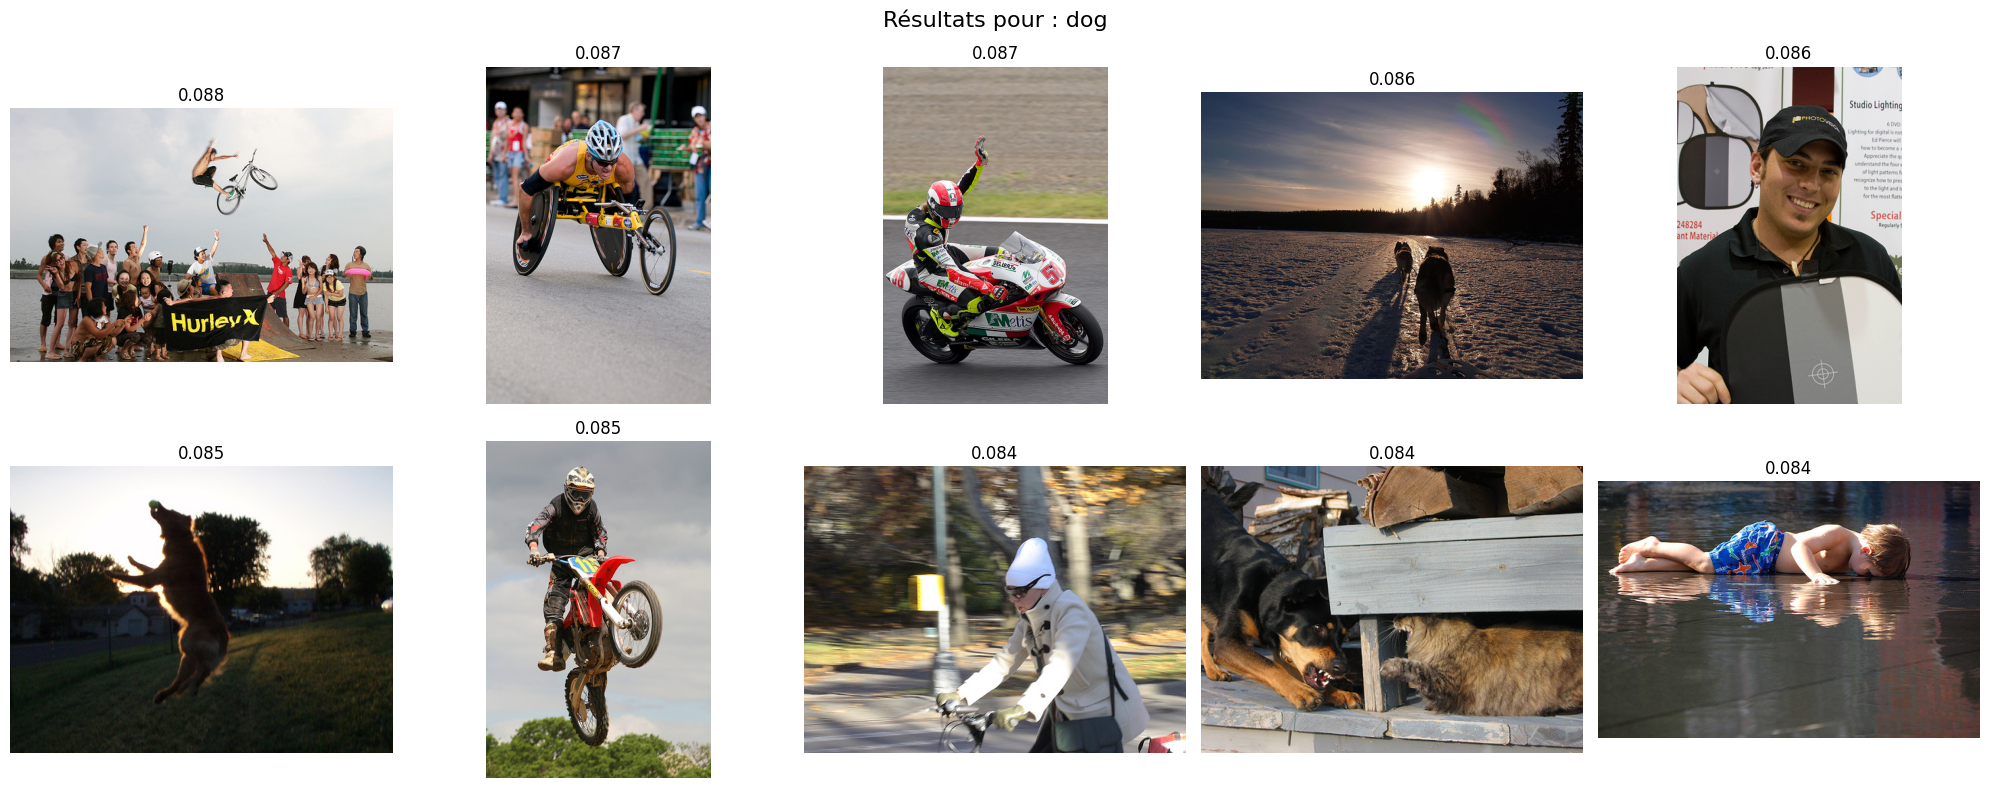

In [ ]:
url = "https://www.lirmm.fr/~poncelet/Ressources/flickr_long_subset.zip"
target_dir = "flickr_subset2"

# Vérifie si le dossier existe déjà
if os.path.exists(target_dir) and os.path.isdir(target_dir):
    print("Données déjà disponibles dans :", target_dir)
else:
    print("Téléchargement de flickr_subset2.zip...")
    response = requests.get(url)
    if response.status_code == 200:
        print("Téléchargement réussi. Extraction...")
        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
            # Extraire sans ajouter de sous-dossier supplémentaire
            for member in zip_ref.namelist():
                # Corrige les chemins pour ignorer un éventuel prefixe flickr_subset2/
                member_path = member
                if member.startswith("flickr_subset2/"):
                    member_path = member[len("flickr_subset2/"):]
                target_path = os.path.join(target_dir, member_path)

                # Si c'est un répertoire, on le crée
                if member.endswith("/"):
                    os.makedirs(target_path, exist_ok=True)
                else:
                    os.makedirs(os.path.dirname(target_path), exist_ok=True)
                    with zip_ref.open(member) as source, open(target_path, "wb") as target:
                        target.write(source.read())
        print(f"Données extraites dans : {target_dir}")
    else:
        print("Échec du téléchargement. Code HTTP :", response.status_code)
# --- Variables globales attendues par main() ---
model_dir = "./models_forclip"
os.makedirs(model_dir, exist_ok=True)

dataset_dir = "./flickr_subset2"
image_dir = os.path.join(dataset_dir, "images")
captions_dir = os.path.join(dataset_dir, "captions")

# IMPORTANT: ton code utilise captions_csv_path ainsi
captions_csv_path = os.path.join(dataset_dir, "captions.csv")

# Paramètres utiles
image_size = (224, 224)
image_shape = image_size + (3,)

sequence_length = 32
vocab_size = 10000
embed_dim = 128

if __name__ == "__main__":
    main()
